
# <center>Spatial Analysis of California Housing Data</center>

## <center>Abstract</center>

### <center>Keywords:</center>

## 1. Introduction
In this blog post, I analyze housing prices across California using a combination of geospatial and satellite image data.  The goal is to find a model that can describe the spatial variation in housing prices across California, the "target" variable, **y**.  We'll start by building a simple, linear model that only uses the eight housing market characteristics (i.e. features) in the original dataset described in Pace et al. [1997], **X**, which contains the following columns: 

0) Median income in cluster, 
1) Average age of housing in cluster, 
2) Average rooms in cluster, 
3) Average bedrooms in cluster, 
4) Total population in cluster, 
5) Average occupancy in cluster, 
6) Latitude of cluster centroid, and
7) Longitude of cluster centroid, 

This model provides a baseline for comparison with the more complicated models we'll build later.

Our first code block below loads the california housing dataset, **calh**, plus it does some important prep work.  In particular, we import three packages, *numpy*, *matplotlib*, and *sklearn*.  They can be downloaded and installed via a package manager, pip, etc.  Note, however, that it can be a bit tricky to install matplotlib's Basemap toolkit with all its dependencies (see link below), but Basemap is only needed for the later part of the analysis that includes features from satellite images.  Finally, we define all of our parameters in the first code block (see comments below for details).


### References
Bency, A.J., S. Rallapalli, R.K. Ganti, M. Srivatsa, and B.S. Manjunath (2016), Beyond Spatial Auto-Regressive Models: Predicting Housing Prices with Satellite Imagery, Applications of Computer Vision (WACV), 2017 IEEE Winter Conference, 
http://ieeexplore.ieee.org/abstract/document/7926625/.

Pace, R.K. and R. Barry, Sparse Spatial Autoregressions, Statistics and Probability Letters, 33 (1997) 291-297.

http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

http://www.irvinalmonte.com/wp-content/uploads/2016/10/IrvinAlmonte_Brief_Spatio-Temporal_Data_R.pdf

https://github.com/bsmurphy/PyKrige/blob/master/examples/regression_kriging2d.py


In [1]:
%matplotlib inline

# Using Web Map Tile Service (WMPS) to get satellite images
# Following http://www.net-analysis.com/blog/cartopyimages.html
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets.california_housing import fetch_california_housing
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ARDRegression, ElasticNet, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, RepeatedKFold, cross_validate
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
# Adjust size of figures
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [52]:
# ALL parameters are defined in this cell
# Define data and "pre" preprocessing parameters
# Run next cell for list of features
# latlon_ll = latitude, longitude of map lower-left corner in degrees
# latlon_ur = latitude, longitude of map upper-right corner in degrees
# If latlon_ll and/or latlon_ur are empty, then they are set to the minimum 
# and maximum lat, lon across all data points
# If both latlon_ll and latlon_ur are provided and filter_latlons = True, then
# only data points within latlon_ll and latlon_ur are included in the feature
# array, X, and the target variable, y.
latlon_ids = [6, 7]
filter_latlons = True
latlon_ll = [38.8, -124.6]
latlon_ur = [42.2, -119.8]
remove_outliers = True
rm_feature_inds = [5]
rm_feature_upth = [100]
rm_feature_loth = [None]
plot_projection = "mercator"

# Preprocessing
prepro_method = "standardscaler"
prepro_params = {"copy": False}
prepro_features = False
prepro_target = False

# Define Regression (reg) parameters
# reg_feature_ids = the indices of the features to include in regression, e.g. to
reg_feature_ids = [0, 1, 2, 3, 4, 5, 6, 7]
# CV parameters
# Parameters
# List of regress(ion) methods: LinearRegression, Ridge, Lasso, ElasticNet,
# SGDRegressor, ARDRegression, LinearSVR, SVR, BayesianRidge, RANSACRegressor, 
# GaussianProcessRegressor, AdaBoostRegressor, GradientBoostingRegressor, 
# Number of random trials
NUM_TRIALS = 50
model_method = "Validate-Test"
val_nsplits = 3
test_nsplits = 4
scale_grid = [None, preprocessing.StandardScaler()]
regress_grid = [LinearRegression(), ElasticNet(), LinearSVR()]
#C_grid = [0.1, 1]
#epsilon_grid = [0.05, 0.1]
alpha_grid = [1e-5, 1e-4, 1e-3]
l1rat_grid = [0.01, 0.1, 0.5, 0.9, 0.99]
p_grid = [ \
        #{
        #'scale': [scale_grid[1]], \
        #'regress': [regress_grid[0]]
        #}, \
        {
        'scale': [scale_grid[1]], \
        'regress': [regress_grid[1]], \
        'regress__alpha': alpha_grid, \
        'regress__l1_ratio': l1rat_grid
        }
        #{
        #'scale': [scale_grid[1]], \
        #'regress': [regress_grid[2]], \
        #'regress__C': C_grid, \
        #'regress__epsilon': epsilon_grid
        #}
]
# Define Plotting parameters
# Write figures to file as string savefig*, use empty string to show figure
# instead of saving it
savefig_val = "val_trainval_scores_elanet.png"
savefig_test = "test_valtest_scores_elanet.png"

In [43]:
# Function definitions
# Collect input data
def get_inputs_dict(data_dict="California Housing", keys_to_get=[], mapxy_projection="mercator"):
    """Get input data stored in dict, inputs, which contains:
    1) Feature variables [# Samples, # Features], key='X'
    2) Feature names [# Features], key='feature_names'
    3) Target variable [# Samples], key='y'
    4) *Geographic location variables [# of Samples, # Coordinates (e.g. x,y)], key='xy'
    5) Dataset description [single string of text], key='DESCR'
    * Note, the cartopy package MUST be installed to build geographic (xy) variables.  If this requirement 
    is met, two additional variables will be appended to inputs: a) a "geodetic" coordinate reference frame 
    (CRF) object, key="geodetic_CRS", and b) a "cartesian" map projection CRF, key="mapxy_CRS". Currently, 
    only mapxy_projection="mercator" is supported.
    Input data_dict is a string "pointing" to a method for loading a data dictionary.
    Currently only California Housing dataset is available: data_dict="California Housing"
    """
    inputs = {}
    if data_dict == "California Housing":
        if len(keys_to_get) == 0:
            keys_to_get = ['X', 'y', 'xy', 'feature_names', 'DESCR']
        # Load data and extract selected features
        # (Down)load California housing data
        chd = fetch_california_housing()
        # Extract features and target from input dataset
        if "X" in keys_to_get:
            inputs['X'] = chd.data
        if "y" in keys_to_get:
            inputs['y'] = chd.target
            #inputs['y'] = inputs['y'].reshape(inputs['y'].shape[0], -1)
        if "xy" in keys_to_get:
            # Extract separate feature array that contains the lat/lon features 
            # converted to x/y coordinates.
            inputs['geodetic_CRS'] = ccrs.Geodetic()
            if mapxy_projection == "mercator":
                inputs['mapxy_CRS'] = ccrs.Mercator()
            inputs['xy'] = convert_latlon_to_xy(chd.data[:, latlon_ids], inputs['mapxy_CRS'], \
                    inputs['geodetic_CRS']
            )
        if "feature_names" in keys_to_get:
            inputs['feature_names'] = chd.feature_names
        if "DESCR" in keys_to_get:
            inputs['DESCR'] = chd.DESCR
    else:
        print("Error, unrecognized data_dict value = {}".format(data_dict))
    return inputs

# Preprocessing functions
# Get analysis dict
def get_analysis_dict(inputs, keys_to_copy=['X', 'y', 'xy']):
    """Get the analysis dictionary, analysis, which is instantiated here with a copy of the X, y, and
    xy variables from the input dict, inputs, if they exist.  This dict is used as a container for all
    preprocessing/modeling data. Note that all subsequent data stored in the analysis dict should be 
    stored under either the preprocessing or modeling key.
    """
    return {k: v.copy() for k, v in inputs.items() if k in keys_to_copy}

# Filter data rows by latitude and longitude
def prepro_filter_by_latlon(data, latlon_ids, latlon_ll, latlon_ur):
    """Return subset (i.e. filter) of rows of feature array, X, target, y, (and optionally xy) based 
    on lower-left and upper-right latitude and longitude pairs, latlon_ll and latlon_ur, respectively.
    Filter is applied if filter_latlons=True and latlon_ll and latlon_ur are each of length 2.  
    latlon_ids = a two-element list containing the column indices corresponding to latitude and
    longitude variables in the feature array, X.  Returns input dict, data, with filtered X, y, and xy.
    """ 
    latlon_mask = (data['X'][:, latlon_ids[0]] >= latlon_ll[0]) & \
            (data['X'][:, latlon_ids[0]] <= latlon_ur[0]) & \
            (data['X'][:, latlon_ids[1]] >= latlon_ll[1]) & \
            (data['X'][:, latlon_ids[1]] <= latlon_ur[1])
    data['X'] = data['X'][latlon_mask, :]
    data['y'] = data['y'][latlon_mask]
    if "xy" in data:
        data['xy'] = data['xy'][latlon_mask, :]
    return data

def prepro_remove_outliers(data, rm_feature_inds, rm_feature_loth, rm_feature_upth):
    for ind, fid in enumerate(rm_feature_inds):
        if rm_feature_upth[ind]:
            out_mask = data['X'][:, fid]<rm_feature_upth[ind]
            data['X'] = data['X'][out_mask, :]
            data['y'] = data['y'][out_mask]
            data['xy'] = data['xy'][out_mask, :]
        if rm_feature_loth[ind]:
            out_mask = data['X'][:, fid]>rm_feature_loth[ind]
            data['X'] = data['X'][out_mask, :]
            data['y'] = data['y'][out_mask]
            data['xy'] = data['xy'][out_mask, :]
    return data

# Model Score plotting functions
def plot_scores_image(fig, ax, array, aspect=1):
    cax = ax.imshow(array, aspect=aspect, origin="lower")
    fig.colorbar(cax)

def get_bin_edges_width(arr1, arr2, bin_step):
    bin_min = np.min([arr1.min(), arr2.min()])
    bin_max = np.max([arr1.max(), arr2.max()])
    bin_edges = np.arange(bin_min, bin_max+bin_step, bin_step)
    bin_width = bin_edges[1] - bin_edges[0]
    return bin_edges, bin_width

def plot_scores_hist_cascade(ax, array, bin_edges):
    hist_height_adj = 0.95
    bin_width_adj = 1
    nr, nc = array.shape
    arr_means = np.mean(array, axis=0)
    arr_stds = np.std(array, axis=0)
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    for ind in range(nc):
        hist, _ = np.histogram(array[:, ind], bins=bin_edges)
        ax.bar(bin_centers, hist_height_adj*hist/hist.max(), align='center', \
               width=bin_width_adj*bin_width, bottom=ind
        )
        ax.plot([arr_means[ind], arr_means[ind]], [ind, ind+1], 'k', linewidth=2)
        ax.plot([arr_means[ind]-arr_stds[ind], arr_means[ind]+arr_stds[ind]], \
                [ind, ind], 'k', linewidth=2
        )
        ax.plot([bin_edges[0], bin_edges[-1]], [ind, ind], 'k', linewidth=1)
    ax.set_xlim([bin_edges[0], bin_edges[-1]])
    ax.set_ylim([0, nc])
    
# Map-related functions
# Convert lat/lon features from geographic coordinates to x/y coordinates
def convert_latlon_to_xy(latlon, crs1, crs2):
    """Convert latitude/longitude array in x/y array using coordinate reference
    systems, crs1 and crs2.  Returns array of x/y values
    """
    xy = np.zeros((latlon.shape[0], 2))
    for ri, (lat, lon) in enumerate(latlon):
        xy[ri,:] = crs1.transform_point(lon, lat, crs2)
    return xy

def make_UnNestCV_summary_plot(arr1, arr2, arr3, bin_edges, bin_centers, bin_width):
    fig = plt.figure()
    # Training Summary plot
    ax1 = plt.subplot(2, 1, 1)
    hist, _ = np.histogram(arr1, bins=bin_edges)
    ax1.bar(bin_centers, hist/hist.max(), align='center', width=bin_width, color='k')
    ax1.set_title("Un-Nested CV Training Scores")
    #ax1.set_xlabel("Score of Bin Center")
    ax1.set_ylabel("Counts/Max(Counts)")
    # Validation Summary plot
    ax2 = plt.subplot(2, 1, 2)
    hist, _ = np.histogram(arr2, bins=bin_edges)
    ax2.bar(bin_centers, hist/hist.max(), align='center', width=bin_width, color='r', \
            label="All Scores for All Estimators"
    )
    hist, _ = np.histogram(arr3, bins=bin_edges)
    ax2.bar(bin_centers, hist/hist.max(), align='center', width=bin_width, color='b', \
           label="Mean CV Score for each iteration's 'Best' Estimator")
    ax2.set_title("Un-Nested CV Validation Scores")
    ax2.set_xlabel("Score of Bin Center")
    ax2.set_ylabel("Counts/Max(Counts)")
    plt.legend(loc="best")
    plt.show()

def make_NestCV_summary_plot(arr1, arr2, bin_edges, bin_centers, bin_width):
    fig = plt.figure()
    # Training Summary plot
    ax1 = plt.subplot(2, 1, 1)
    hist, _ = np.histogram(arr1, bins=bin_edges)
    ax1.bar(bin_centers, hist/hist.max(), align='center', width=bin_width, color='r')
    ax1.set_title("Nested CV Validation Scores")
    #ax1.set_xlabel("Score of Bin Center")
    ax1.set_ylabel("Counts/Max(Counts)")
    # Validation Summary plot
    ax2 = plt.subplot(2, 1, 2)
    hist, _ = np.histogram(arr2, bins=bin_edges)
    ax2.bar(bin_centers, hist/hist.max(), align='center', width=bin_width, color='b')
    ax2.set_title("Nested CV Testing Scores")
    ax2.set_xlabel("Score of Bin Center")
    ax2.set_ylabel("Counts/Max(Counts)")
    plt.show()


In [44]:
# Load inputs dictionary containing input variables from source
inputs = get_inputs_dict()
print("Feature names (in order): \n{}\n".format(inputs['feature_names']))
#print("Data description: \n{}\n".format(inputs['DESCR']))

# Load analysis dictionary containing preprocessing and modeling variables, including
# a copy of the feature array, X, the target variable, y, and the spatial variable, xy.
# First, filter the data by selecting a subset of the rows of X, y, and (optionally) xy, 
# based on user provided lower-left and upper-right lat/lons pairs. Filter is applied if 
# filter_latlons=True and latlon_ll and latlon_ur are each of length 2
analysis = get_analysis_dict(inputs)
analysis = prepro_filter_by_latlon(analysis, latlon_ids, latlon_ll, latlon_ur)
if remove_outliers:
    analysis = prepro_remove_outliers(analysis, rm_feature_inds, rm_feature_loth, rm_feature_upth)

Feature names (in order): 
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']



In [45]:
print(inputs['X'].shape, analysis['X'].shape)

(20640, 8) (1176, 8)


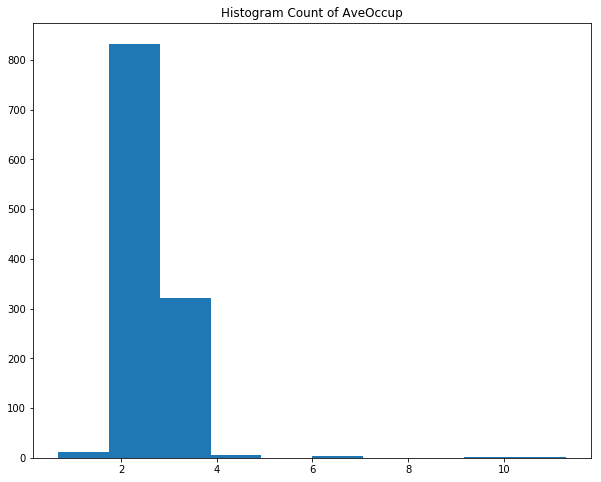

In [46]:
# Plot target variable (median housing price) vs specified feature variable
plt_featid = 5
feature_name = inputs['feature_names'][plt_featid]
#plt.scatter(analysis['X'][:, plt_featid], analysis['y'], color='black')
#plt.hist(analysis['X'][:, plt_featid]) #, bins=np.arange(0, 40000, 1000))
plt.hist(analysis['X'][:, plt_featid])
#plt.ylim([0, 10])
#plt.title("Median Housing Price vs. {}".format(feature_name))\
plt.title("Histogram Count of {}".format(feature_name))
plt.show()

# Plot target residuals (difference between model and data) vs specified 
# feature variable
#chd_y_res = chd_y_test - chd_y_pred
#resmax_ind = chd_y_res.argmax()
#plt.scatter(inputs['X']_train[:,plt_featid], chd_y_train,  color='black')
#plt.scatter(inputs['X']_test[:,plt_featid], chd_y_test,  color='red')
#plt.scatter(inputs['X']_test[:,plt_featid], chd_y_res, color='blue')
#plt.title("Residual Price vs. {}".format(feature_name))
#plt.show()

In [53]:
# Select hyperparameters using Un-Nested Cross-Validation and/or Evaluate model performance
# using Nested Cross-Validation
# Portions modified after http://scikit-learn.org/stable/auto_examples/
# Make pipeline
pipe = Pipeline([('scale', preprocessing.StandardScaler()), \
                ('regress', LinearRegression())]
)
# Perform model selection and/or evaluation for a set of random trials.
# There are two modes of operation: 1) "Validate": Model exploration/selection using grid 
# search to evaluate different models/hyper-parameters via un-nested Cross-Validation (UCV). 
# This option only splits the data into training and validation sets, and provides score/error 
# estimates across a grid of different methods/hyper-parameters, but these estimates may be 
# significantly biased, so this option is best for parameter grid tuning, early-stage model
# exploration, etc., but score estimates etc. are not good for evaluating model performance
# 2) "Test": Model selection AND performance evaluation using grid search and CV for 
# validation in an "inner loop", and then using (nested) CV in an "outer loop", to evalute 
# the inner, validation model's expected performance on new, "unseen" samples.  This option
# splits the data into training, validation, and testing sets and picks an "optimal" model 
# internally (i.e. in the inner loop), based only on the training and validation datasets.
# The model in this case encompasses the entire GridSearch object, including the chosen
# CV method and the parameter grid.
# 3) "Validate-Test": Runs both 1 and 2 above for model exploration, debugging, etc.

# If model_method starts with "Validate", store v_train_scores and v_val_scores for each
# loop in lists 
# If model_method ends with "Test", store t_val_scores and t_test_scores in lists

if model_method.startswith("Validate"):
    v_train_scores = []
    v_val_scores = []
    v_val_score_bests = []
    v_val_score_ranks = []
if model_method.endswith("Test"):
    t_val_scores = []
    t_test_scores = []

print("Running Model {} method".format(model_method))
for i in range(NUM_TRIALS):
    print("Trial #{}".format(i))
    # First part of Validation Step no matter the method: instantiate 1) CV class that
    # defines validation "loop" sampling strategy, and 2) Grid search CV class for 
    # estimation of optimal modeleling step(s)/hyper-parameter(s)
    val_cv = KFold(n_splits=val_nsplits, shuffle=True, random_state=i)
    clf = GridSearchCV(estimator=pipe, param_grid=p_grid, cv=val_cv)
    if model_method.startswith("Validate"):
        print("Validating...")
        clf.fit(analysis['X'], analysis['y'])
        if i == 0:
            v_params = clf.cv_results_['params']
        key_suf = ["_train_score", "_test_score"]
        for ns in range(val_nsplits):
            v_train_scores.append(clf.cv_results_["split"+str(ns)+key_suf[0]])
            v_val_scores.append(clf.cv_results_["split"+str(ns)+key_suf[1]])
        v_val_score_bests.append(clf.best_score_)
        v_val_score_ranks.append(clf.cv_results_['rank_test_score'])
            
    if model_method.endswith("Test"):
        # Testing: Evaluate model performance using outer loop sampling strategy defined
        # by test_cv and inner loop as defined for "Validate" above
        print("Testing...")
        test_cv = KFold(n_splits=test_nsplits, shuffle=True, random_state=i)
        t_scores = cross_validate(clf, X=analysis['X'], y=analysis['y'], cv=test_cv)
        t_val_scores.append(t_scores["train_score"])
        t_test_scores.append(t_scores["test_score"])

if model_method.startswith("Validate"):
    v_train_scores = np.array(v_train_scores)
    v_val_scores = np.array(v_val_scores)
    v_val_score_bests = np.array(v_val_score_bests)
    v_val_score_ranks = np.array(v_val_score_ranks, dtype="int")
    vt_score_means = v_train_scores.mean(axis=0)
    vv_score_means = v_val_scores.mean(axis=0)
    vv_score_rank_means = v_val_score_ranks.mean(axis=0)
    vt_score_stds = v_train_scores.std(axis=0)
    vv_score_stds = v_val_scores.std(axis=0)
    vv_score_rank_stds = v_val_score_ranks.std(axis=0)
if model_method.endswith("Test"):
    t_val_scores = np.array(t_val_scores)
    t_test_scores = np.array(t_test_scores)
    tv_score_means = t_val_scores.mean(axis=0)
    tt_score_means = t_test_scores.mean(axis=0)
    tv_score_stds = t_val_scores.std(axis=0)
    tt_score_stds = t_test_scores.std(axis=0)
print("Finished!")

Running Model Validate-Test method
Trial #0
Validating...
Testing...
Trial #1
Validating...
Testing...
Trial #2
Validating...
Testing...
Trial #3
Validating...
Testing...
Trial #4
Validating...
Testing...
Trial #5
Validating...
Testing...
Trial #6
Validating...
Testing...
Trial #7
Validating...
Testing...
Trial #8
Validating...
Testing...
Trial #9
Validating...
Testing...
Trial #10
Validating...
Testing...
Trial #11
Validating...
Testing...
Trial #12
Validating...
Testing...
Trial #13
Validating...
Testing...
Trial #14
Validating...
Testing...
Trial #15
Validating...
Testing...
Trial #16
Validating...
Testing...
Trial #17
Validating...
Testing...
Trial #18
Validating...
Testing...
Trial #19
Validating...
Testing...
Trial #20
Validating...
Testing...
Trial #21
Validating...
Testing...
Trial #22
Validating...
Testing...
Trial #23
Validating...
Testing...
Trial #24
Validating...
Testing...
Trial #25
Validating...
Testing...
Trial #26
Validating...
Testing...
Trial #27
Validating...
Testin

Total # of Samples Included in Regression = 1176
GridCV Parameter grid: 
[{'scale': StandardScaler(copy=True, with_mean=True, with_std=True), 'regress__l1_ratio': 0.01, 'regress': ElasticNet(alpha=1e-05, copy_X=True, fit_intercept=True, l1_ratio=0.01,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False), 'regress__alpha': 1e-05}, {'scale': StandardScaler(copy=True, with_mean=True, with_std=True), 'regress__l1_ratio': 0.1, 'regress': ElasticNet(alpha=1e-05, copy_X=True, fit_intercept=True, l1_ratio=0.01,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False), 'regress__alpha': 1e-05}, {'scale': StandardScaler(copy=True, with_mean=True, with_std=True), 'regress__l1_ratio': 0.5, 'regress': ElasticNet(alpha=1e-05, copy_X=True, fit_intercept=True, l1_ratio=0.01,
      max_iter=1000, normalize=False, positive

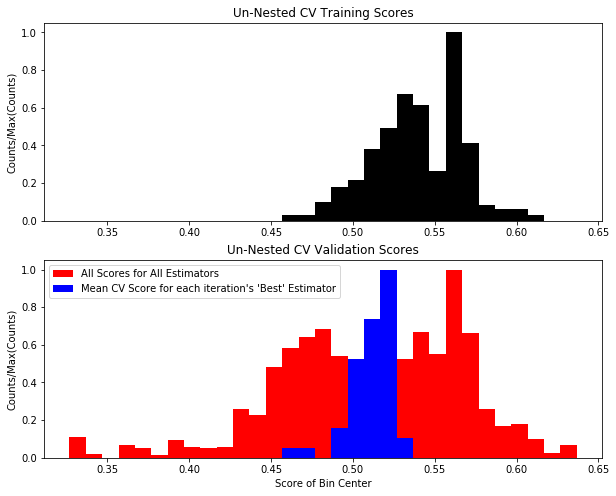

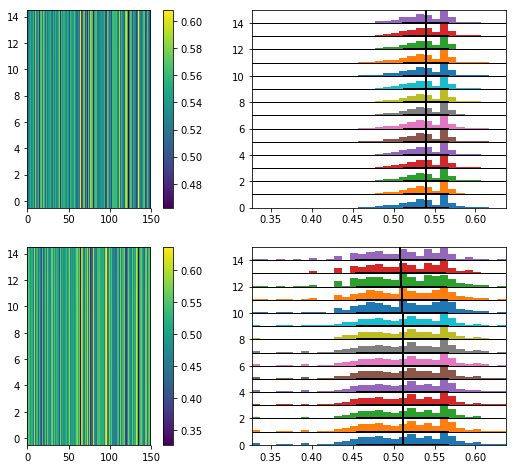

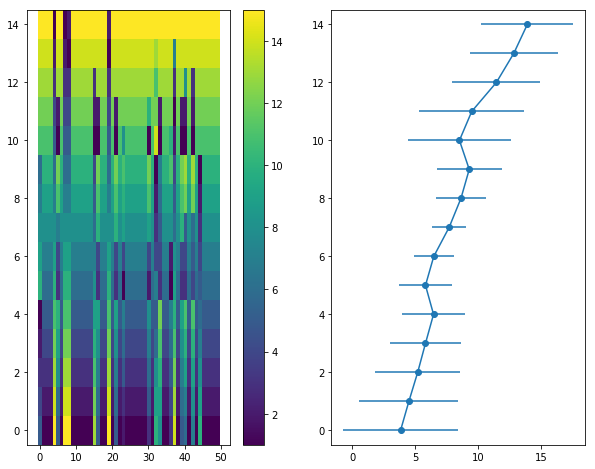

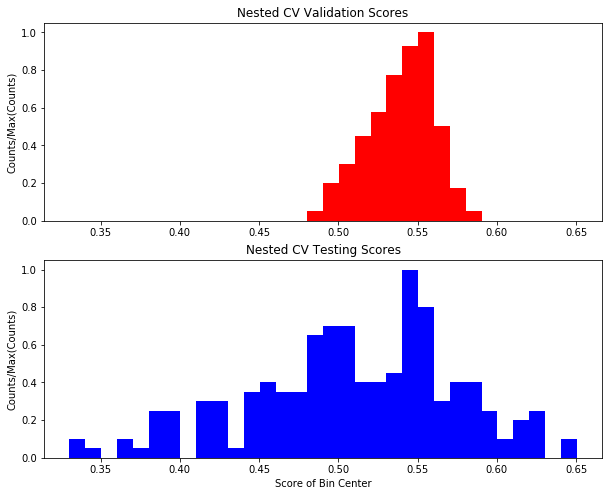


Un-Nested Validation, Training Score: Mean of Estimator Means, Estimator Means +/- St. Devs.:
0.539642732636834, [ 0.5397289   0.5397289   0.53972889  0.53972887  0.53972887  0.53972791
  0.53972771  0.53972654  0.53972486  0.53972441  0.53963613  0.53961724
  0.53950092  0.53932885  0.539282  ] +/- [ 0.02728154  0.02728154  0.02728155  0.02728155  0.02728155  0.02728134
  0.02728134  0.0272814   0.02728156  0.02728161  0.02726221  0.02726221
  0.02726779  0.02728298  0.02728782]
Un-Nested Validation, Validation Score: Mean of Estimator Means, Estimator Means +/- St. Devs.:
0.5104593437509408, [ 0.51104014  0.51103893  0.51103358  0.5110282   0.51102699  0.51099658
  0.5109842   0.51092828  0.5108709   0.51085779  0.51044468  0.5102875
  0.50949577  0.50854669  0.50830992] +/- [ 0.05557919  0.05557815  0.05557354  0.05556891  0.05556787  0.05551114
  0.05550088  0.05545538  0.0554101   0.05539996  0.05490647  0.05481703
  0.05444763  0.0541424   0.05408522]
Un-Nested Validation, Mean 

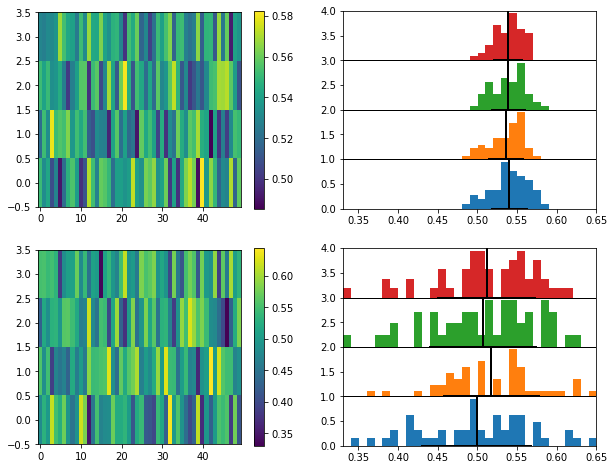

In [54]:
print("Total # of Samples Included in Regression = {}".format(analysis['X'].shape[0]))
if model_method.startswith("Validate"):
    print("GridCV Parameter grid: \n{}".format(v_params))
    print(v_train_scores.shape)
    print(vv_score_rank_means, vv_score_rank_stds)
    # Make image plot and/or histogram plot from un-nested CV Gridsearch for
    # 1) training scores, v_train_scores, and 2) validation scores, v_val_scores
    # Set aspect ratio of image plot
    v_aspect = 16
    # Calculate bin locations
    bin_step = 0.01
    bin_edges, bin_width = get_bin_edges_width(v_train_scores, v_val_scores, bin_step)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Make summary figure showing score value histograms for all un-nested training and
    # validation data
    make_UnNestCV_summary_plot(v_train_scores.ravel(), v_val_scores.ravel(), v_val_score_bests, \
            bin_edges, bin_centers, bin_width
    )
    
    # Make figure showing score values versus fold/trial, estimator, both as 
    # "raw" images and as histograms
    fig = plt.figure()
    ax1 = plt.subplot(2, 2, 1)
    plot_scores_image(fig, ax1, v_train_scores.T, aspect=v_aspect)
    ax2 = plt.subplot(2, 2, 2)
    plot_scores_hist_cascade(ax2, v_train_scores, bin_edges)
    ax3 = plt.subplot(2, 2, 3)
    plot_scores_image(fig, ax3, v_val_scores.T, aspect=v_aspect)  
    ax4 = plt.subplot(2, 2, 4)
    plot_scores_hist_cascade(ax4, v_val_scores, bin_edges)
    if len(savefig_val) > 0:
        fig.savefig(savefig_val)
    else:
        plt.show()
    # Make plot of estimator rank versus fold/trial and estimator, as an image
    fig = plt.figure()
    ax1 = plt.subplot(1, 2, 1)
    plot_scores_image(fig, ax1, v_val_score_ranks.T, aspect=np.floor(v_aspect/2))
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    ax2.errorbar(v_val_score_ranks.mean(axis=0), range(v_val_score_ranks.shape[1]), \
            xerr=v_val_score_ranks.std(axis=0), fmt='-o'
    )
    ax2.set_ylim([-0.5, v_val_score_ranks.shape[1]-0.5])
    
if model_method.endswith("Test"):
    # Make image plot and/or histogram plot from nested CV Gridsearch for
    # 1) validation scores, t_val_scores, and 2) test scores, t_test_scores
    # Set aspect ratio of image plot
    t_aspect = 12
    # Calculate bin locations
    bin_step = 0.01
    bin_edges, bin_width = get_bin_edges_width(t_val_scores, t_test_scores, bin_step)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Make summary figure showing score value histograms for all nested validation and
    # test data
    make_NestCV_summary_plot(t_val_scores.ravel(), t_test_scores.ravel(), \
            bin_edges, bin_centers, bin_width
    )
    #fig = plt.figure()
    #ax1 = plt.subplot(2, 1, 1)
    #ax1.hist(t_val_scores.ravel(), bins=bin_edges)
    #ax2 = plt.subplot(2, 1, 2)
    #ax2.hist(t_test_scores.ravel(), bins=bin_edges)
    #plt.show()
    
    # Make figure
    fig = plt.figure()
    ax1 = plt.subplot(2, 2, 1)
    plot_scores_image(fig, ax1, t_val_scores.T, aspect=t_aspect)
    ax2 = plt.subplot(2, 2, 2)
    plot_scores_hist_cascade(ax2, t_val_scores, bin_edges)
    ax3 = plt.subplot(2, 2, 3)
    plot_scores_image(fig, ax3, t_test_scores.T, aspect=t_aspect)  
    ax4 = plt.subplot(2, 2, 4)
    plot_scores_hist_cascade(ax4, t_test_scores, bin_edges)
    if len(savefig_test) > 0:
        fig.savefig(savefig_test)
    else:
        plt.show()
    
if model_method == "Validate-Test":
    print("\nUn-Nested Validation, Training Score: Mean of Estimator Means, Estimator Means +/- St. Devs.:")
    print("{}, {} +/- {}".format(vt_score_means.mean(), vt_score_means, vt_score_stds))
    print("Un-Nested Validation, Validation Score: Mean of Estimator Means, Estimator Means +/- St. Devs.:")
    print("{}, {} +/- {}".format(vv_score_means.mean(), vv_score_means, vv_score_stds))
    print("Un-Nested Validation, Mean Score of each Best_Estimator: Max Best Score, Mean Best Score +/- St. Dev.:")
    print("{}, {} +/- {}".format(v_val_score_bests.max(), v_val_score_bests.mean(), v_val_score_bests.std()))
    print("\nNested Test, Validation Score: Mean of Fold Means, Fold Means +/- St. Devs.:")
    print("{}, {} +/- {}".format(tv_score_means.mean(), tv_score_means, tv_score_stds))
    print("Nested Test, Test Score: Mean of Fold Means, Fold Means +/- St. Devs.:")
    print("{}, {} +/- {}".format(tt_score_means.mean(), tt_score_means, tt_score_stds))

In [ ]:
print(v_val_scores.max())

In [ ]:
print(t_val_scores.shape)

In [23]:
help(clf)

Help on GridSearchCV in module sklearn.model_selection._search object:

class GridSearchCV(BaseSearchCV)
 |  Exhaustive search over specified parameter values for an estimator.
 |  
 |  Important members are fit, predict.
 |  
 |  GridSearchCV implements a "fit" and a "score" method.
 |  It also implements "predict", "predict_proba", "decision_function",
 |  "transform" and "inverse_transform" if they are implemented in the
 |  estimator used.
 |  
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated grid-search over a parameter grid.
 |  
 |  Read more in the :ref:`User Guide <grid_search>`.
 |  
 |  Parameters
 |  ----------
 |  estimator : estimator object.
 |      This is assumed to implement the scikit-learn estimator interface.
 |      Either estimator needs to provide a ``score`` function,
 |      or ``scoring`` must be passed.
 |  
 |  param_grid : dict or list of dictionaries
 |      Dictionary with parameters names (string) as k

In [36]:
print(v_val_scores.ravel().shape)

(1500,)
